# Toronto AirBNB analysis

- How big is the demand for airBNB housing?
- What can a host expect wrt occupancy and earning in Toronto? 
- Factors influencing demand for airBNB


# Loading the data

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('seaborn')
import seaborn as sns
import folium

import warnings
warnings.filterwarnings("ignore")

In [2]:
df_raw = pd.read_csv('data/reviews.csv')
df_raw.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,1419,38924112,2015-07-19,11308465,Marcela,Having the opportunity of arriving to Alexandr...
1,1419,44791978,2015-08-29,9580285,Marco,We have no enough words to describe how beauty...
2,1419,45957133,2015-09-07,38394721,Andrea,The listing was exceptional and an even better...
3,1419,67295154,2016-03-28,3515044,Shaun,Alexandra's home was amazing and in such a nea...
4,1419,177702208,2017-08-03,13987100,Kate,Beautiful home. Very comfortable and clean. Pe...


In [3]:
# drop unnecessary columns
df_raw.drop(['reviewer_id', 'reviewer_name', 'comments'], axis=1, inplace=True)

# rename id column to a column to count review 
df_raw.rename({'id': 'review_count'}, axis=1, inplace=True)
df_raw.review_count = 1

# check shape and dups
print("The first dataset has {} rows and {} columns.".format(*df_raw.shape))
print("It contains {} duplicates.".format(df_raw.duplicated().sum()))

df_raw.head()

The first dataset has 653723 rows and 3 columns.
It contains 1569 duplicates.


,listing_id,review_count,date
0,1419,1,2015-07-19
1,1419,1,2015-08-29
2,1419,1,2015-09-07
3,1419,1,2016-03-28
4,1419,1,2017-08-03


# Reviews per month

In [4]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 653723 entries, 0 to 653722
Data columns (total 3 columns):
listing_id      653723 non-null int64
review_count    653723 non-null int64
date            653723 non-null object
dtypes: int64(2), object(1)
memory usage: 15.0+ MB


In [5]:
df_raw.date = pd.to_datetime(df_raw.date, format="%Y-%m-%d")

In [6]:
df_raw.date.describe()

count                  653723
unique                   3101
top       2019-08-05 00:00:00
freq                     2379
first     2009-08-20 00:00:00
last      2019-12-07 00:00:00
Name: date, dtype: object

In [7]:
df_raw.date.dtype

dtype('<M8[ns]')

In [8]:
count_2018_19 = df_raw[df_raw['date'].isin(pd.date_range('2018-10-01', '2019-11-30'))]
print("the dataset 2018/19 has {} has reviews and {} columns.".format(*count_2018_19.shape))

the dataset 2018/19 has 327146 has reviews and 3 columns.


In [9]:
count_2018_19 = count_2018_19.set_index('date').sort_index()

In [10]:
count_2018_19_monthly = count_2018_19.groupby([pd.Grouper(freq='M'), 'listing_id'])['review_count']\
                        .agg({'review_count': {'reviews_per_month': 'count'}})\
                        .reset_index()

In [11]:
count_2018_19_monthly.head()

,date,listing_id,review_count
,,,reviews_per_month
0,2018-10-31,23691,3
1,2018-10-31,26654,1
2,2018-10-31,40456,2
3,2018-10-31,41887,4
4,2018-10-31,43964,1


In [12]:
# define column names after flattening the multi-index above
count_2018_19_monthly.columns = ['date', 'listing_id', 'reviews_per_month']

# set date as index again 
count_2018_19_monthly.set_index('date', inplace=True)

# check again
count_2018_19_monthly.head()

,listing_id,reviews_per_month
date,,
2018-10-31,23691,3
2018-10-31,26654,1
2018-10-31,40456,2
2018-10-31,41887,4
2018-10-31,43964,1


In [13]:
count_2018_19_monthly[count_2018_19_monthly.listing_id==23691]

,listing_id,reviews_per_month
date,,
2018-10-31,23691,3
2018-11-30,23691,2
2018-12-31,23691,1
2019-04-30,23691,2
2019-08-31,23691,1
2019-09-30,23691,1
2019-10-31,23691,4


In [14]:
# remove index
count_2018_19_monthly = count_2018_19_monthly.reset_index()

# group by listing_id & count reviews
count_2018_19_monthly = pd.DataFrame(count_2018_19_monthly.groupby('listing_id')['reviews_per_month'].mean()\
                          .reset_index())

count_2018_19_monthly.head()

,listing_id,reviews_per_month
0,23691,2.000
1,26654,1.000
2,40456,1.625
3,41887,1.500
4,43964,1.200


In [15]:
df_2 = pd.read_csv('data/listings.csv')
df_2.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,1419,https://www.airbnb.com/rooms/1419,20191207213017,2019-12-08,Beautiful home in amazing area!,"This large, family home is located in one of T...",Visit Toronto with this fabulous furnished hom...,"This large, family home is located in one of T...",none,The apartment is located in the Ossington stri...,...,f,f,strict_14_with_grace_period,f,f,1,1,0,0,0.13
1,8077,https://www.airbnb.com/rooms/8077,20191207213017,2019-12-08,Downtown Harbourfront Private Room,Guest room in a luxury condo with access to al...,My husband and I are both artists. I give pain...,Guest room in a luxury condo with access to al...,none,NaN,...,t,f,strict_14_with_grace_period,f,t,2,1,1,0,1.35
2,12604,https://www.airbnb.com/rooms/12604,20191207213017,2019-12-08,Seaton Village Parlour Bedroom,Comfortable sofa bed in airy main floor parlour.,Family of 4 (2 kids) plus a friendly dog open...,Comfortable sofa bed in airy main floor parlou...,none,NaN,...,f,f,moderate,f,f,1,0,1,0,NaN
3,23691,https://www.airbnb.com/rooms/23691,20191207213017,2019-12-08,Queen Bedroom close to downtown,NaN,Nestled in the middle of a quiet residential n...,Nestled in the middle of a quiet residential n...,none,NaN,...,t,f,strict_14_with_grace_period,f,f,2,0,2,0,1.85
4,26654,https://www.airbnb.com/rooms/26654,20191207213017,2019-12-08,World Class downtown @CN Tower Theatre MTCC ga...,"CN Tower, TIFF Bell Lightbox, Metro Convention...",Welcome to 5***** Living - Bohemian decor~ in ...,"CN Tower, TIFF Bell Lightbox, Metro Convention...",none,There's a reason they call it the Entertainmen...,...,f,f,strict_14_with_grace_period,f,f,7,7,0,0,0.35


In [16]:
nb_list = pd.read_csv('data/nb_list.csv')

In [17]:
# merging
df = pd.merge(count_2018_19_monthly, pd.merge(df_2, nb_list, on='neighbourhood')[
                                          ['id', 'price', 'cleaning_fee',
                                           'neighbourhood', 'district', 'district_sub', 
                                           'latitude', 'longitude', 'property_type', 'accommodates',
                                           'bathrooms', 'bedrooms', 'bed_type', 'host_is_superhost']],
                    left_on='listing_id', right_on='id')

# drop id from dataframe
df.drop(['id'], axis=1, inplace=True)

print("The dataset has {} rows and {} columns - after combining it.".format(*df.shape))
print("It contains {} duplicates.".format(df.duplicated().sum()))

df.head()

The dataset has 15765 rows and 15 columns - after combining it.
It contains 0 duplicates.


,listing_id,reviews_per_month,price,cleaning_fee,neighbourhood,district,district_sub,latitude,longitude,property_type,accommodates,bathrooms,bedrooms,bed_type,host_is_superhost
0,23691,2.000,$72.00,$0.00,Fairbank,York,York,43.69602,-79.45468,House,3,1.0,1.0,Real Bed,t
1,26654,1.000,$199.00,$51.00,Downtown Toronto,Old Toronto,Old Toronto - Central,43.64530,-79.38940,Condominium,5,1.0,1.0,Real Bed,f
2,40456,1.625,$99.00,$125.00,Parkdale,Old Toronto,Old Toronto - West End,43.63532,-79.44049,House,5,1.0,2.0,Real Bed,t
3,41887,1.500,$69.00,$40.00,Oakridge,Scarborough,Scarborough,43.69466,-79.28667,Apartment,2,1.0,0.0,Real Bed,t
4,43964,1.200,$90.00,$30.00,Wexford/Maryvale,Scarborough,Scarborough,43.74858,-79.29111,Bungalow,4,1.0,2.0,Real Bed,f


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15765 entries, 0 to 15764
Data columns (total 15 columns):
listing_id           15765 non-null int64
reviews_per_month    15765 non-null float64
price                15765 non-null object
cleaning_fee         14512 non-null object
neighbourhood        15764 non-null object
district             15764 non-null object
district_sub         15764 non-null object
latitude             15765 non-null float64
longitude            15765 non-null float64
property_type        15765 non-null object
accommodates         15765 non-null int64
bathrooms            15764 non-null float64
bedrooms             15759 non-null float64
bed_type             15765 non-null object
host_is_superhost    15571 non-null object
dtypes: float64(5), int64(2), object(8)
memory usage: 1.9+ MB


In [19]:
# convert price to numeric
df.price = df.price.str.replace('$', '').str.replace(',', '').astype(float).astype(int)
df.price.isna().sum()

0

In [20]:
# replace missing values with zero and convert cleaning_fee to numeric
df.cleaning_fee.fillna('$0.00', inplace=True)
df.cleaning_fee = df.cleaning_fee.str.replace('$', '').str.replace(',', '').astype(float).astype(int)
df.cleaning_fee.isna().sum()

0

In [21]:
df['price'].describe()

count    15765.000000
mean       137.495465
std        199.351934
min          0.000000
25%         65.000000
50%         99.000000
75%        160.000000
max      12001.000000
Name: price, dtype: float64

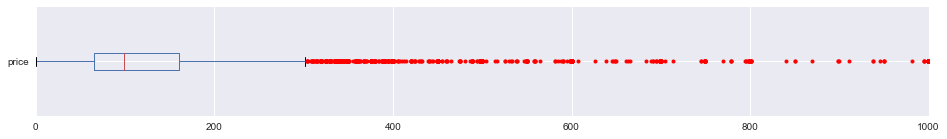

In [22]:
# boxplot of price
red_square = dict(markerfacecolor='r', markeredgecolor='r', marker='.')
df['price'].plot(kind='box', xlim=(0, 1000), vert=False, flierprops=red_square, figsize=(16,2));

In [23]:
df.drop(df[df['price'] > 300].index, axis=0, inplace=True)
df['price'].describe()

count    14888.000000
mean       112.619828
std         63.957861
min          0.000000
25%         64.000000
50%         99.000000
75%        150.000000
max        300.000000
Name: price, dtype: float64

1. Estimated # of visitors per listing in a given time period = number of reviews per month / reviews rate 
2. Monthly occupancy rate = average length of stay * (No. of reviews per month/ review rate)


In [26]:
avg_length_of_stay_toronto = 5.4
# http://files.newswire.ca/1503/airbnbONrep.PDF
review_rate_modest = 0.5 

# modest rate of occupancy
df['modest_occupancy'] = round(avg_length_of_stay_toronto * (df['reviews_per_month']/ review_rate_modest), 2)

# check occupancy that are greater than 100 
len(df[df['modest_occupancy'] > 100])

236

In [27]:
# drop occupancy rates > 100
df.drop(df[(df['modest_occupancy'] > 100)].index, axis=0, inplace=True)

# check the distribution
df['modest_occupancy'].describe()

count    14652.000000
mean        28.539914
std         19.165245
min         10.800000
25%         13.200000
50%         21.600000
75%         37.800000
max         99.900000
Name: modest_occupancy, dtype: float64

In [28]:
# Optimistic estimate 

review_rate_optimistic = 0.4

# calculate the occupancy 
df['optimistic_occupancy'] = round(avg_length_of_stay_toronto * (df['reviews_per_month']/review_rate_optimistic), 2) 

# greater than 100 
len(df[df['optimistic_occupancy'] > 100])

397

In [29]:
# drop occupancy rates > 100
df.drop(df[(df['optimistic_occupancy'] > 100)].index, axis=0, inplace=True)

# check for distribution 
df['optimistic_occupancy'].describe()

count    14255.000000
mean        33.601077
std         20.733259
min         13.500000
25%         16.200000
50%         27.000000
75%         45.000000
max         99.900000
Name: optimistic_occupancy, dtype: float64

Text(27.8, 3500, 'Median (Optimistic Estimate)')

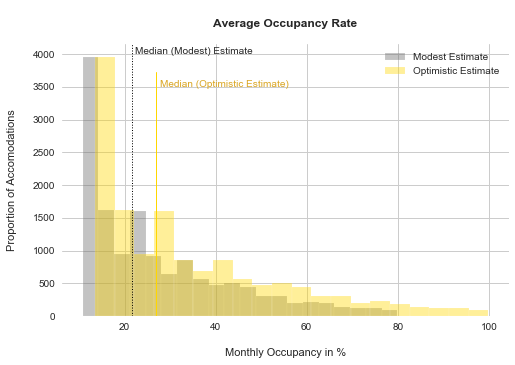

In [34]:
sns.set_style("whitegrid")
plt.figure(figsize=(8,5))

sns.distplot(df["modest_occupancy"], kde=False, bins=20, color="dimgrey")
sns.distplot(df["optimistic_occupancy"], kde=False, bins=20, color="gold")

plt.title("\nAverage Occupancy Rate\n", fontweight="bold")
plt.legend(["Modest Estimate", "Optimistic Estimate"])
plt.xlabel("\nMonthly Occupancy in %")
plt.ylabel("Proportion of Accomodations\n")

# median w/ modest estimate
plt.axvline(x=21.6, ymin=0, ymax=1, linewidth=1, linestyle=':', color='black')
plt.text(22.3, 4000, "Median (Modest) Estimate")

# median w/ optimistic estimate
plt.axvline(x=27, ymin=0, ymax=0.9, linewidth=1, linestyle='-', color='gold')
plt.text(27.8, 3500, "Median (Optimistic Estimate)", color="goldenrod")

In [35]:
df['modest_income'] = df['modest_occupancy'] * df['price'] * 12
df.modest_income.describe()

count     14255.000000
mean      37539.367155
std       34973.794010
min           0.000000
25%       13413.600000
50%       25920.000000
75%       49766.400000
max      286056.000000
Name: modest_income, dtype: float64

In [36]:
df['optimistic_income'] = df['optimistic_occupancy'] * df['price'] * 12
df.optimistic_income.describe()

count     14255.000000
mean      46924.214378
std       43717.165594
min           0.000000
25%       16767.000000
50%       32400.000000
75%       62208.000000
max      357552.000000
Name: optimistic_income, dtype: float64

Text(33000, 1000, 'Median (Optimistic Estimate)')

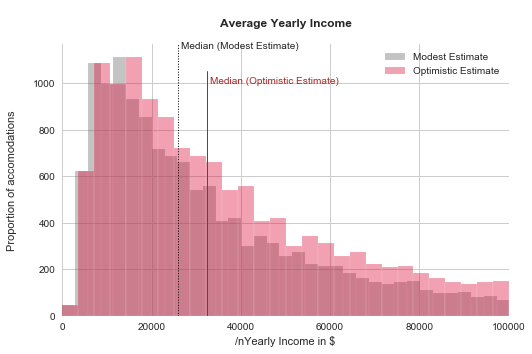

In [42]:
sns.set_style("whitegrid")
plt.figure(figsize=(8,5))

sns.distplot(df['modest_income'], kde=False, bins=100, color="dimgrey")
sns.distplot(df['optimistic_income'], kde=False, bins=100, color="crimson")

plt.title('\nAverage Yearly Income\n', fontweight='bold')
plt.legend(['Modest Estimate', 'Optimistic Estimate'])
plt.xlabel('/nYearly Income in $')
plt.xlim((0,100000))
plt.ylabel('Proportion of accomodations\n')

plt.axvline(x=25920, ymin=0, ymax=1, linewidth=1, linestyle=':', color='black')
plt.text(26520, 1150, 'Median (Modest Estimate)')

plt.axvline(x=32400, ymin=0, ymax=0.9, linewidth=1, linestyle='-', color='firebrick')
plt.text(33000, 1000, 'Median (Optimistic Estimate)', color='firebrick')

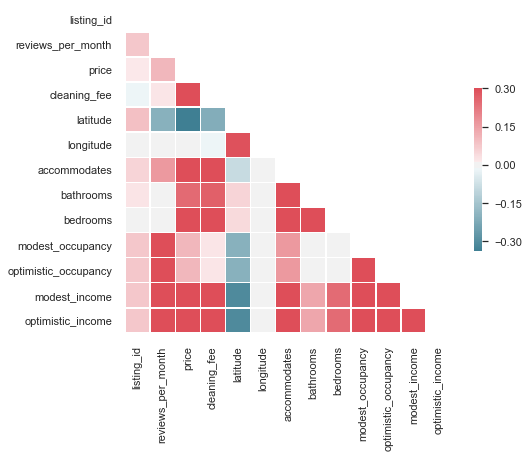

In [44]:
sns.set(style="white")
corr = df.corr()

# mask for upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# setup matplotlib fig
fig, ax = plt.subplots(figsize=(8, 6))

# generate custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink":.5});

From this chart, we see 2 things
- number of people can be accommodate -> indicator for size or capacity
- latitude -> proxy for location to explain the demand 

seasonality?
super host status -> gets more guests than standard host?
 

In [45]:
df_raw["date"].describe()

count                  653723
unique                   3101
top       2019-08-05 00:00:00
freq                     2379
first     2009-08-20 00:00:00
last      2019-12-07 00:00:00
Name: date, dtype: object

In [46]:
# split data by date
count_2019 = df_raw[df_raw["date"].isin(pd.date_range('2019-01-01', '2019-12-07'))]
count_2018 = df_raw[df_raw["date"].isin(pd.date_range('2018-01-01', '2018-12-31'))]
count_2017 = df_raw[df_raw["date"].isin(pd.date_range('2017-01-01', '2017-12-31'))]
count_2016 = df_raw[df_raw["date"].isin(pd.date_range('2016-01-01', '2016-12-31'))]

# set date as index and sort by it
count_2019 = count_2019.set_index("date").sort_index()
count_2018 = count_2018.set_index("date").sort_index()
count_2017 = count_2017.set_index("date").sort_index()
count_2016 = count_2016.set_index("date").sort_index()

# calculate reviews per month
count_2019_monthly = count_2019.groupby([pd.Grouper(freq='M'), 'listing_id'])['review_count']\
                     .agg({'review_count': {'reviews_per_month_19': 'count'}})\
                     .reset_index()

count_2018_monthly = count_2018.groupby([pd.Grouper(freq='M'), 'listing_id'])['review_count']\
                     .agg({'review_count': {'reviews_per_month_18': 'count'}})\
                     .reset_index()

count_2017_monthly = count_2017.groupby([pd.Grouper(freq='M'), 'listing_id'])['review_count']\
                     .agg({'review_count': {'reviews_per_month_17': 'count'}})\
                     .reset_index()

count_2016_monthly = count_2016.groupby([pd.Grouper(freq='M'), 'listing_id'])['review_count']\
                     .agg({'review_count': {'reviews_per_month_16': 'count'}})\
                     .reset_index()

# flatten the multi-index
count_2019_monthly.columns=['date', 'listing_id', 'reviews_per_month_19']
count_2018_monthly.columns=['date', 'listing_id', 'reviews_per_month_18']
count_2017_monthly.columns=['date', 'listing_id', 'reviews_per_month_17']
count_2016_monthly.columns=['date', 'listing_id', 'reviews_per_month_16']

# set date as index
count_2019_monthly.set_index('date', inplace=True)
count_2018_monthly.set_index('date', inplace=True)
count_2017_monthly.set_index('date', inplace=True)
count_2016_monthly.set_index('date', inplace=True)

Text(0.04, 0.5, 'Average Reviews per Month')

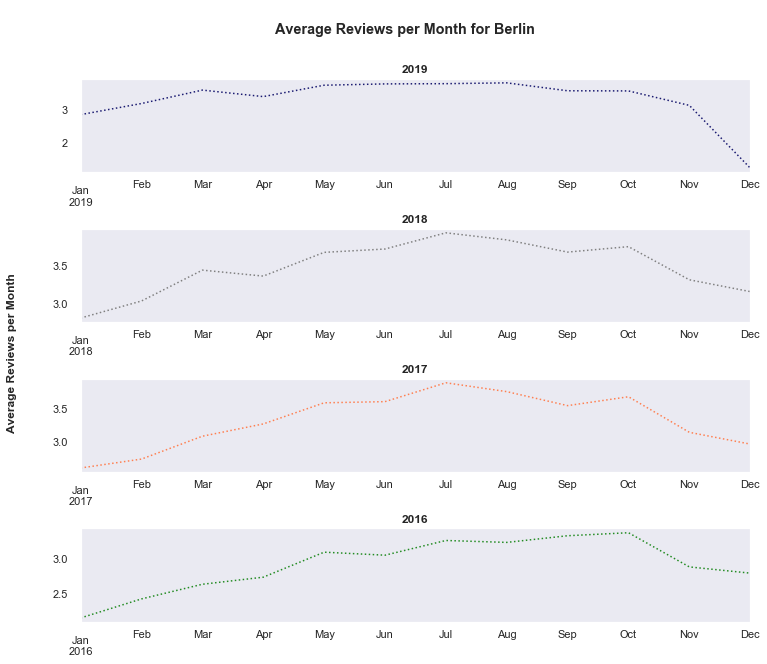

In [49]:
sns.set(style="dark")

fig, axes = plt.subplots(4, 1, figsize=(12,10))

sub_1 = count_2019_monthly.groupby('date')['reviews_per_month_19'].mean()
sub_1.plot(ax=axes[0], color='midnightblue', style=':')
axes[0].set_title('2019', fontweight='bold')
axes[0].set_xlabel('')

sub_2 = count_2018_monthly.groupby('date')['reviews_per_month_18'].mean()
sub_2.plot(ax=axes[1], color='grey', style=':')
axes[1].set_title('2018', fontweight='bold')
axes[1].set_xlabel('')

sub_3 = count_2017_monthly.groupby('date')['reviews_per_month_17'].mean()
sub_3.plot(ax=axes[2], color='coral', style=':')
axes[2].set_title('2017', fontweight='bold')
axes[2].set_xlabel('')

sub_4 = count_2016_monthly.groupby('date')['reviews_per_month_16'].mean()
sub_4.plot(ax=axes[3], color='forestgreen', style=':')
axes[3].set_title('2016', fontweight='bold')
axes[3].set_xlabel('')

# adjust space b/w subplots and set title
plt.subplots_adjust(hspace = 0.6)
plt.suptitle('\nAverage Reviews per Month for Berlin\n', fontweight='bold')

# plot common y-label
fig.text(0.04, 0.5, 'Average Reviews per Month', fontweight='bold', va='center', rotation='vertical')

Why does it dip in September?

Plot for 2019 Dec is severely skewed, as the data there is only recorded till Dec 7



In [50]:
df.host_is_superhost.isna().sum()

177

In [51]:
# replace nan w/ false for not being a superhost
df.host_is_superhost.fillna(value='f', inplace=True)
df.host_is_superhost.isna().sum()

0

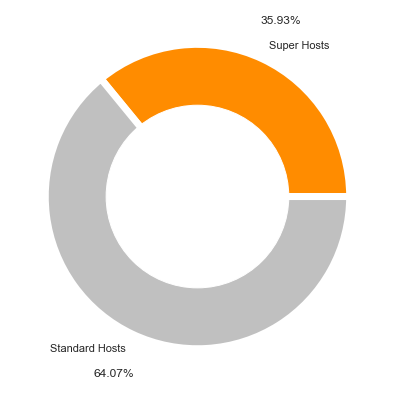

In [52]:
#looking at the difference between superhosts and standard hosts

# assign the data
super_host = df.host_is_superhost.value_counts()['t']
no_super_host = df.host_is_superhost.value_counts()['f']
names = ['Super Hosts', 'Standard Hosts']
size = [super_host, no_super_host]

# create a pie chart
plt.pie(size, labels=names, colors=['darkorange', 'silver'],
       autopct='%.2f%%', pctdistance=1.28,
       wedgeprops={'linewidth':7, 'edgecolor': 'white'})

# create circle in mid to make it a donut
my_circle = plt.Circle((0,0), 0.6, color='white')

# plot the donut chart
fig = plt.gcf()
fig.set_size_inches(7, 7)
fig.gca().add_artist(my_circle)
plt.show()

In [53]:
# Look at median diff b/w superhosts & standard hots
df.groupby('host_is_superhost')['modest_occupancy'].agg(np.median)

host_is_superhost
f    18.90
t    28.47
Name: modest_occupancy, dtype: float64

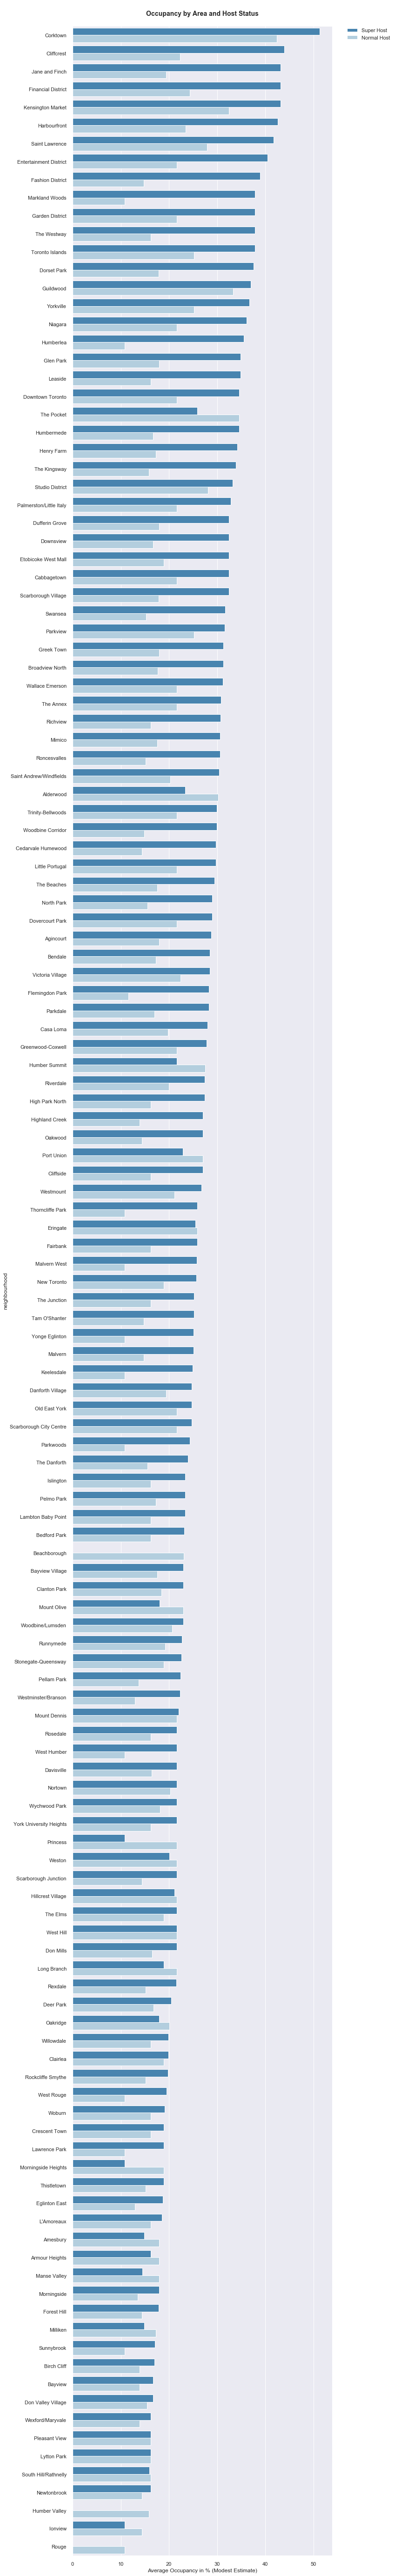

In [56]:
# group by neighbourhod and by status, then take the median occupancy
df_grouped = pd.DataFrame(df.groupby(['neighbourhood', 'host_is_superhost'])['modest_occupancy'].agg(np.median))
df_grouped.sort_values(by='modest_occupancy', ascending=False, inplace=True)
df_grouped.reset_index(inplace=True)

# plot grouped dataframe w/ seaborn
sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=(10, 100))
sns.barplot(x='modest_occupancy', y='neighbourhood', hue='host_is_superhost', hue_order=['t', 'f'],
           data=df_grouped, palette="Blues_r")

# add title and axis label
ax.set_title('\nOccupancy by Area and Host Status\n', fontsize=14, fontweight='bold')
ax.set(xlabel='Average Occupancy in % (Modest Estimate)')

handles, labels = ax.get_legend_handles_labels()
ax.legend((handles), ('Super Host', 'Normal Host'), bbox_to_anchor=(1.05, 1), borderaxespad=0.);

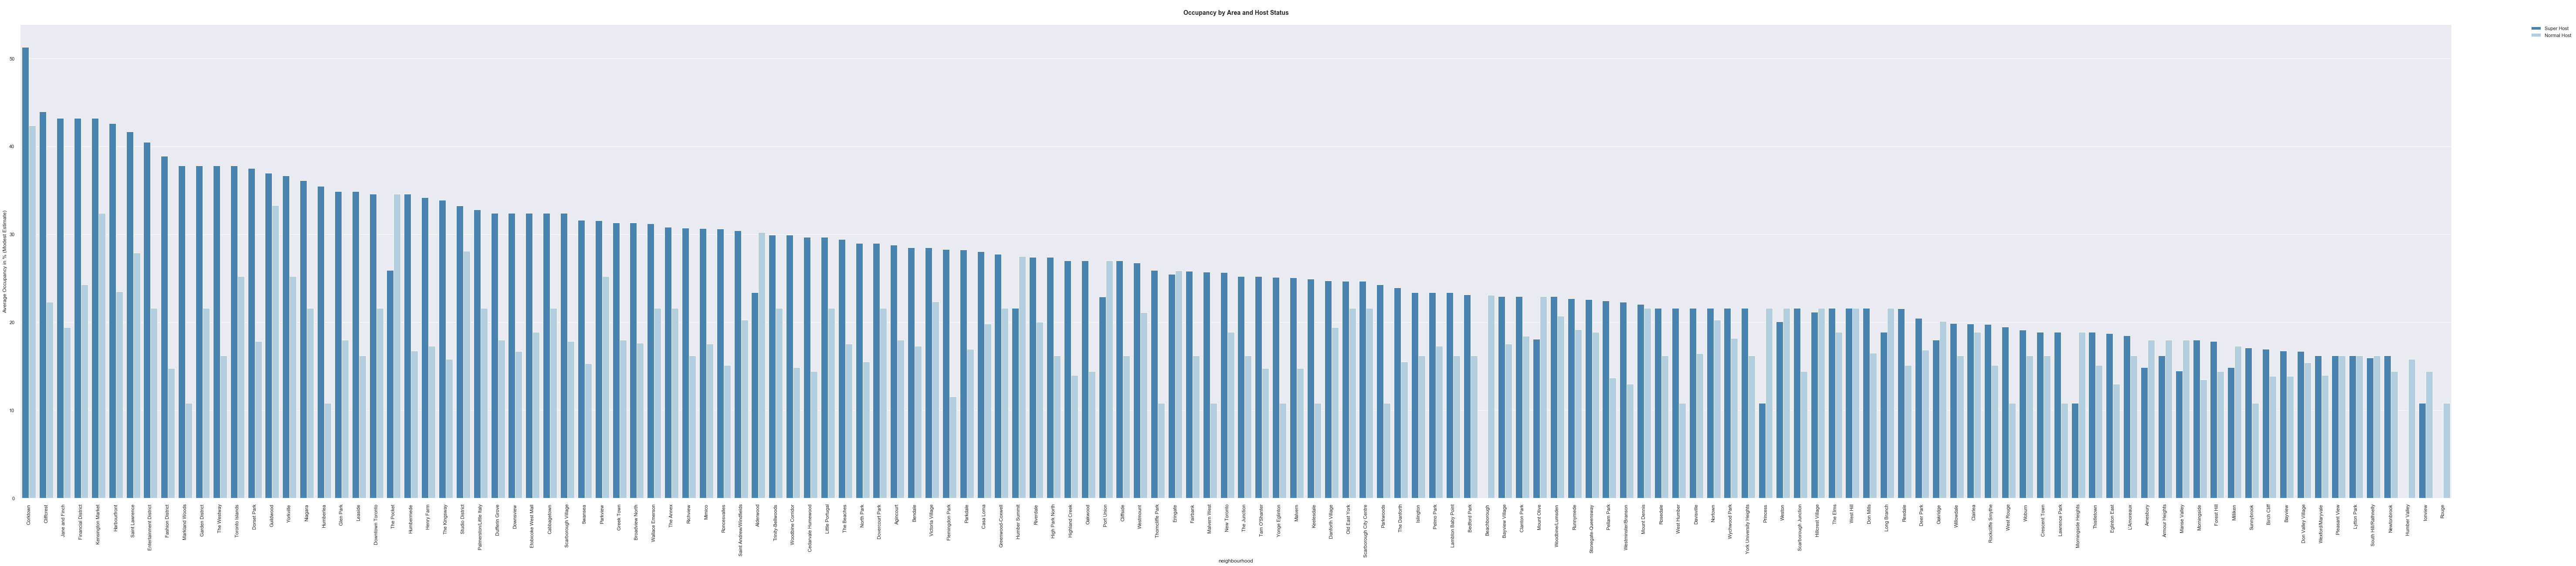

In [69]:
sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=(100, 20))
chart = sns.barplot(x='neighbourhood', y='modest_occupancy', hue='host_is_superhost', hue_order=['t', 'f'],
           data=df_grouped, palette="Blues_r")

# add title and axis label
ax.set_title('\nOccupancy by Area and Host Status\n', fontsize=14, fontweight='bold')
ax.set(ylabel='Average Occupancy in % (Modest Estimate)')

chart.set_xticklabels(chart.get_xticklabels(), rotation=90)

handles, labels = ax.get_legend_handles_labels()
ax.legend((handles), ('Super Host', 'Normal Host'), bbox_to_anchor=(1.05, 1), borderaxespad=0.);

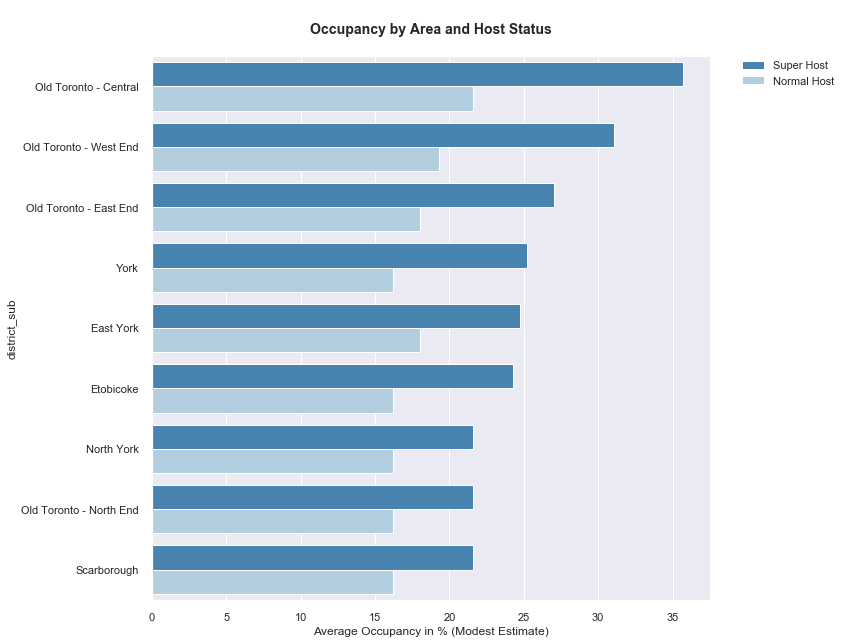

In [73]:
df_grouped = pd.DataFrame(df.groupby(['district_sub', 'host_is_superhost'])['modest_occupancy'].agg(np.median))
df_grouped.sort_values(by='modest_occupancy', ascending=False, inplace=True)
df_grouped.reset_index(inplace=True)

# plot grouped dataframe w/ seaborn
sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=(10, 10))
sns.barplot(x='modest_occupancy', y='district_sub', hue='host_is_superhost', hue_order=['t', 'f'],
           data=df_grouped, palette="Blues_r")

# add title and axis label
ax.set_title('\nOccupancy by Area and Host Status\n', fontsize=14, fontweight='bold')
ax.set(xlabel='Average Occupancy in % (Modest Estimate)')

handles, labels = ax.get_legend_handles_labels()
ax.legend((handles), ('Super Host', 'Normal Host'), bbox_to_anchor=(1.05, 1), borderaxespad=0.);

In [74]:
# difference in the median betweek superhost and standard hosts
df.groupby('host_is_superhost')['modest_income'].agg(np.median)

host_is_superhost
f    22464.0
t    34230.6
Name: modest_income, dtype: float64

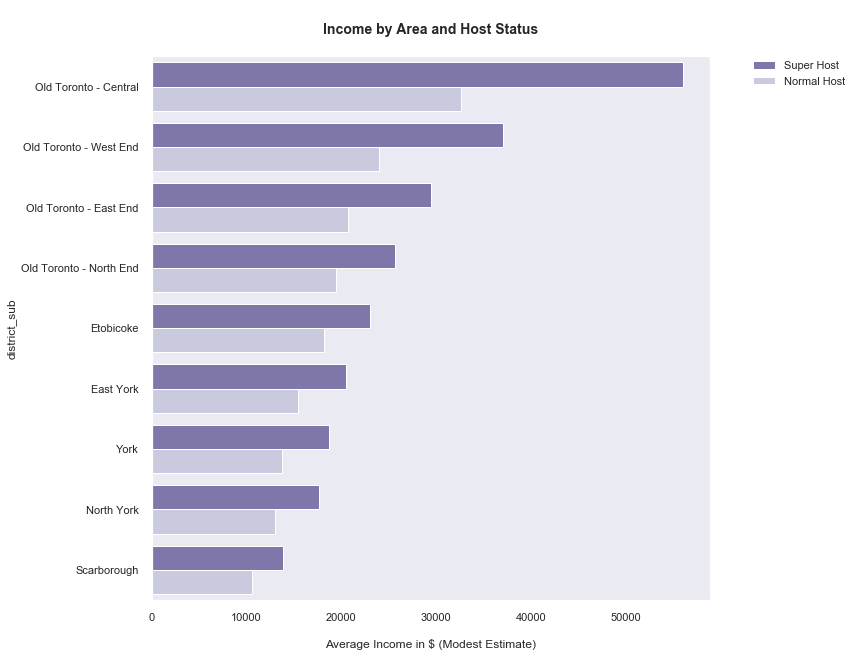

In [76]:
df_grouped = pd.DataFrame(df.groupby(['district_sub', 'host_is_superhost'])['modest_income'].agg(np.median))
df_grouped.sort_values(by='modest_income', ascending=False, inplace=True)
df_grouped.reset_index(inplace=True)

#plot df
sns.set_style('dark')
fig, ax = plt.subplots(figsize=(10,10))
sns.barplot(x='modest_income', y='district_sub', hue='host_is_superhost', hue_order=['t', 'f'],
            data=df_grouped, palette='Purples_r')

ax.set_title('\nIncome by Area and Host Status\n', fontsize=14, fontweight='bold')
ax.set(xlabel='\nAverage Income in $ (Modest Estimate)')

handles, labels = ax.get_legend_handles_labels()
ax.legend((handles), ('Super Host', 'Normal Host'), bbox_to_anchor=(1.25, 1), borderaxespad=0.)

In [85]:
def lollipop_with_2(dataframe, about, y_col, x1_col, x2_col):
    # lollipop chart of 2 observations per group 
    # set style
    sns.set_style("dark")
    
    # prepare data
    df_plot = dataframe[[y_col, x1_col, x2_col]].groupby(y_col).apply(lambda x: x.mean())
    df_plot.sort_values(x1_col, inplace=True)
    df_plot.reset_index(inplace=True)
    
    # draw plot
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.hlines(y=df_plot.index, xmin=df_plot[x1_col], xmax=df_plot[x2_col], color = 'grey', alpha=0.7, linewidth=2)
    ax.scatter(y=df_plot.index, x=df_plot[x1_col], s=75, color='skyblue', alpha=0.7, label=x1_col)
    ax.scatter(y=df_plot.index, x=df_plot[x2_col], s=75, color='darkblue', alpha=0.7, label=x2_col)
    
    ax.set_title('\nAverage ' + about + ' by District\n', fontdict={'size': 12, 'weight': 'bold'})
    ax.set_xlabel('\n' + about)
    ax.set_yticks(df_plot.index)
    ax.set_yticklabels(df_plot[y_col], rotation=0, fontdict={'horizontalalignment': 'right', 'size':12})
    
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()

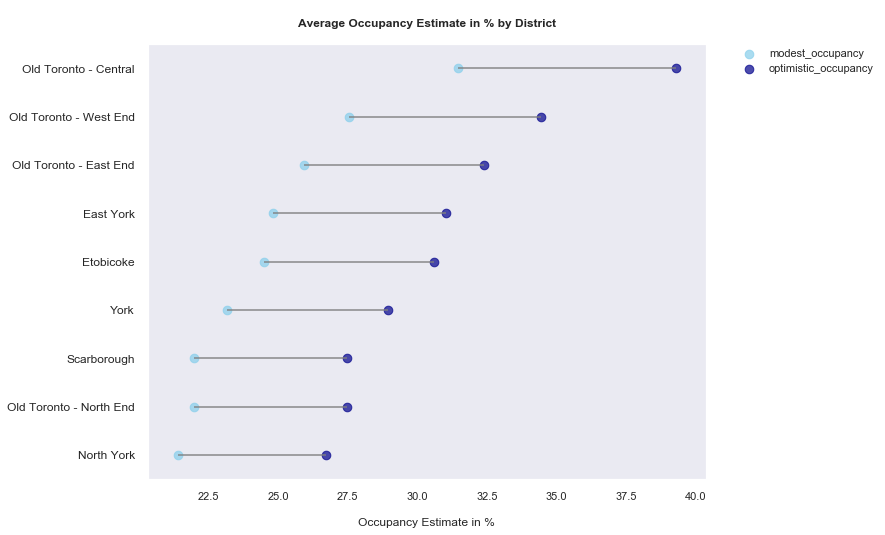

In [86]:
lollipop_with_2(df, 'Occupancy Estimate in %', 'district_sub', 'modest_occupancy', 'optimistic_occupancy')

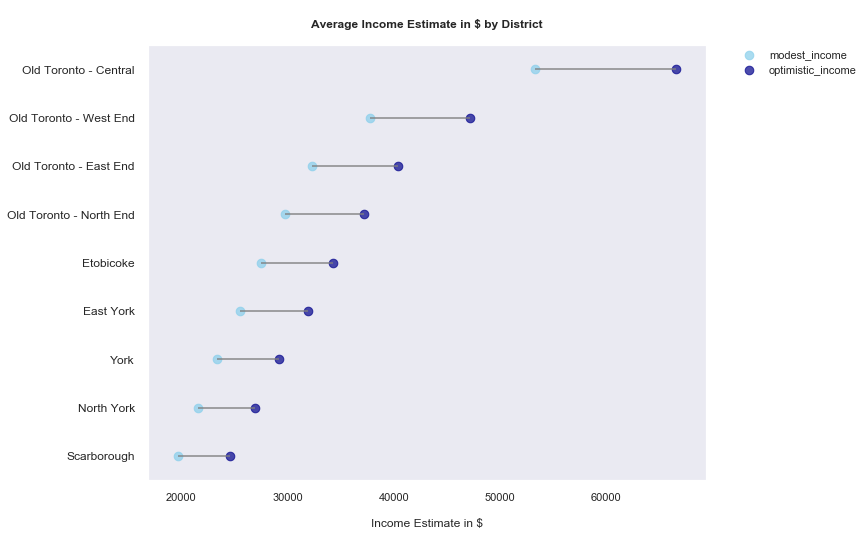

In [87]:
lollipop_with_2(df, 'Income Estimate in $', 'district_sub', 'modest_income', 'optimistic_income')

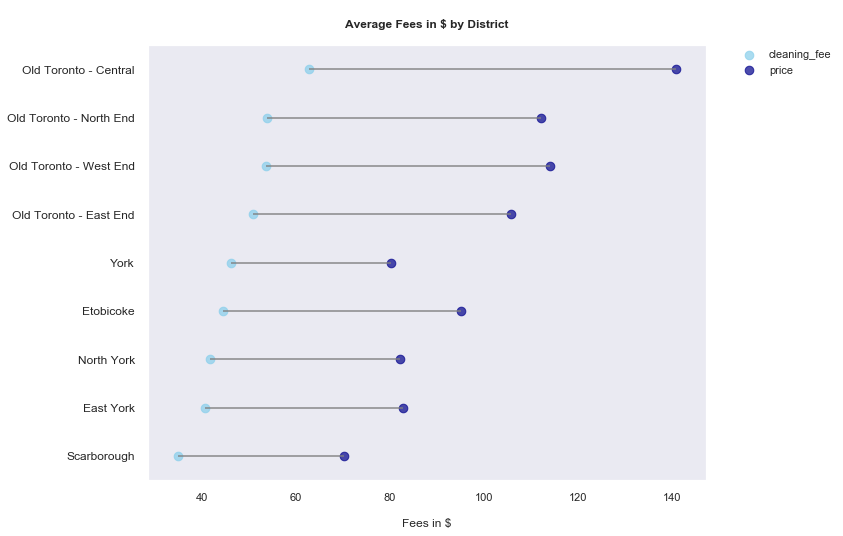

In [88]:
lollipop_with_2(df, 'Fees in $', 'district_sub', 'cleaning_fee', 'price')

In [92]:
def lollipop_with_highlight(dataframe, about, y_col, y_highlight, x_col):
    
    sns.set_style("dark")
    
    df_plot = dataframe[[y_col, x_col]].groupby(y_col).apply(lambda x: x.mean())
    df_plot.sort_values(x_col, inplace=True)
    df_plot.reset_index(inplace=True)
    
    # highlight district specified as y_highlight
    my_color = np.where(df_plot[y_col] == y_highlight, 'crimson', 'skyblue')
    my_size = np.where(df_plot[y_col] == y_highlight, 70, 30)
    
    # draw plot 
    fig, ax = plt.subplots(figsize=(8,8))
    ax.hlines(y=df_plot.index, xmin=0, xmax=df_plot[x_col], color=my_color, alpha=0.5, linewidth=2)
    ax.scatter(y=df_plot.index, x=df_plot[x_col], s=my_size, color=my_color, alpha=1, label=x_col)
    ax.legend()
    
    # title, label, ticks and xlim
    ax.set_title('\nAverage ' + about + ' by District\n', fontdict={'size': 12, 'weight': 'bold'})
    ax.set_xlabel('\n' + about)
    ax.set_yticks(df_plot.index)
    ax.set_yticklabels(df_plot[y_col], rotation=0, fontdict={'horizontalalignment': 'right', 'size': 12})
    
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()

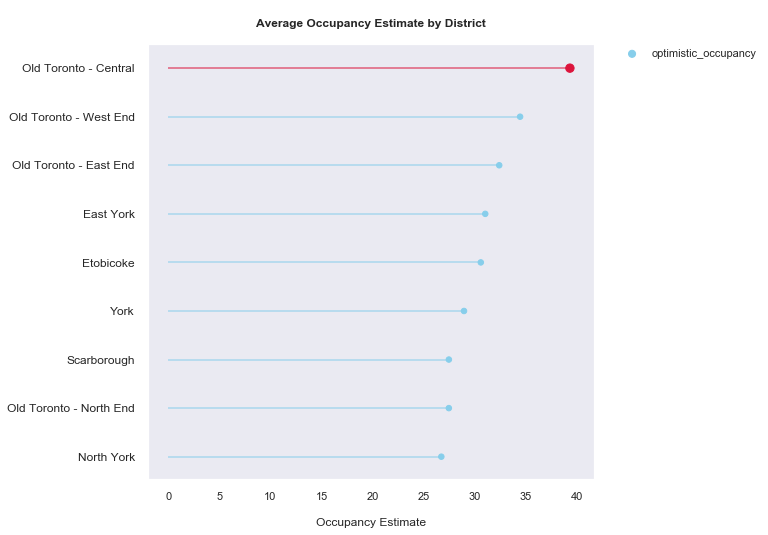

In [93]:
lollipop_with_highlight(df, 'Occupancy Estimate', 'district_sub', 'Old Toronto - Central', 'optimistic_occupancy')

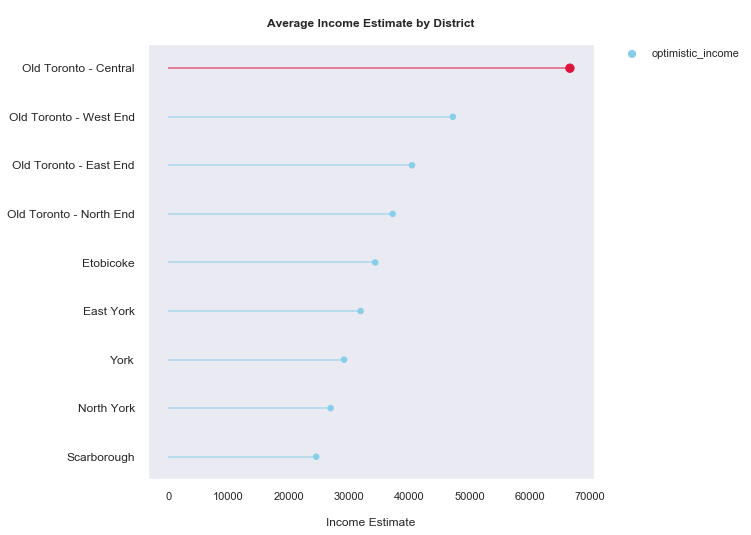

In [94]:
lollipop_with_highlight(df, 'Income Estimate', 'district_sub', 'Old Toronto - Central', 'optimistic_income')

Text(0, 0.5, 'Occupancy (Modest Estimate)\n')

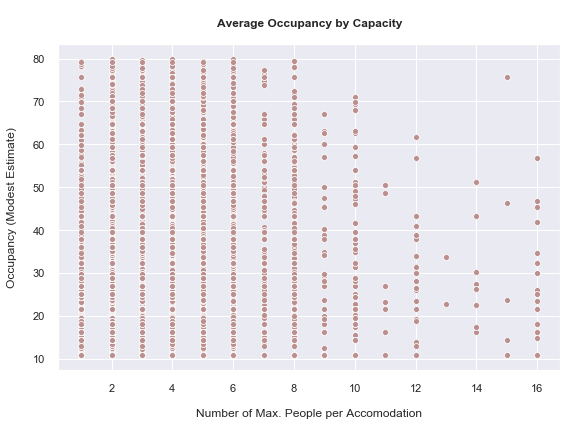

In [96]:
sns.set_style("darkgrid")
fig, ax = plt.subplots(figsize=(9, 6))

sns.scatterplot(x="accommodates", y="modest_occupancy", color="rosybrown", data=df)

plt.title('\nAverage Occupancy by Capacity\n', fontsize=12, fontweight='bold')
plt.xlabel('\nNumber of Max. People per Accomodation')
plt.ylabel('Occupancy (Modest Estimate)\n')

Text(0.5, 1.0, '\nAverage Occupancy by Capacity\n')

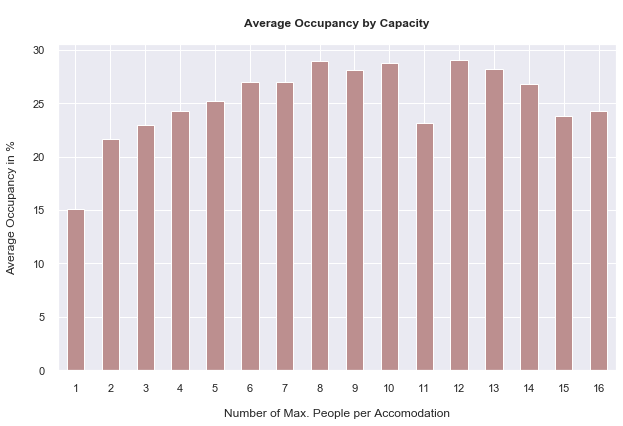

In [98]:
# group by accomodates and plot median occupancy
df.groupby('accommodates')['modest_occupancy']\
                         .median()\
                         .plot(kind='bar', figsize=(10,6), color='rosybrown')

plt.xlabel('\nNumber of Max. People per Accomodation', fontsize=12)
plt.xticks(rotation='horizontal')
plt.ylabel('Average Occupancy in %\n', fontsize=12)
plt.title('\nAverage Occupancy by Capacity\n', fontsize=12, fontweight='bold')


In [101]:
df.groupby('accommodates')['modest_occupancy']\
                         .median().mean()

25.268749999999997